<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2
## Part 1: Data Cleaning and EDA


In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

In [2]:
# df_train is the whole dataset from train.csv
df = pd.read_csv('../datasets/train.csv')

In [3]:
df2_test=pd.read_csv('../datasets/test.csv')

In [4]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
len(df.columns)

81

In [6]:
len(df2_test.columns)

80

In [7]:
len(df2_test.columns)

80

In [8]:
df.columns[-2:]

Index(['Sale Type', 'SalePrice'], dtype='object')

The column that is abscent from the test dataset which is the last column in the training dataset is 'SalePrice'.

#### Data Cleaning

To handel all the 'NA' cells that actually have meangings rather than being absent data. 

From checking the data dictionary at https://www.kaggle.com/c/dsir-426-ames-housing-data, there are 14 columns in the training dataset that 'NA' have actual meanings.

In [9]:
# We make a list of the names of the 14 columns. 
List_to_replace_NA=['Alley','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Fireplace Qu','Garage Type','Garage Finish','Garage Qual','Garage Cond','Pool QC','Fence','Misc Feature']

In [10]:
# We replace these 'NA's in these 14 columns with str 'placeholder'.
for i in range(14):
    df[List_to_replace_NA[i]] = df[List_to_replace_NA[i]].fillna('placeholder')

In [11]:
# Spot check if all this type of NAs have been replaced to 'placeholder's.
df['Bsmt Cond'].unique()

array(['TA', 'Gd', 'placeholder', 'Fa', 'Po', 'Ex'], dtype=object)

In [12]:
# Checking out those 'object' type of columns, to make sure there are not any that should be numerical ones due to undefined entries.
df.select_dtypes(include=['object']).columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type'],
      dtype='object')

Next we check on those columns that are truly with missing data.

In [13]:
# Now check how many NA values there are that are truly missing data.
with_null=df.columns[df.isna().any()].tolist()
len(with_null)
# There are 12 columns that are definitely with real missing data

12

In [14]:
missing_df=pd.DataFrame(df.isna().sum()).reset_index() # w/o reset_index, df_cols become indices
# getting %nulls for cols with missing values
missing_df.columns = ['col', 'num_nulls'] # updating all col names in missing_df
missing_df['%nulls'] = missing_df['num_nulls']*100/len(df) #creating a new col for %nulls (num_nulls/df_len)
missing_df[missing_df['num_nulls']>0] # filter to only cols with any nulls

,col,num_nulls,%nulls
4,Lot Frontage,330,16.089712
26,Mas Vnr Type,22,1.072647
27,Mas Vnr Area,22,1.072647
35,BsmtFin SF 1,1,0.048757
37,BsmtFin SF 2,1,0.048757
38,Bsmt Unf SF,1,0.048757
39,Total Bsmt SF,1,0.048757
48,Bsmt Full Bath,2,0.097513
49,Bsmt Half Bath,2,0.097513
60,Garage Yr Blt,114,5.558264


In [15]:
# For those missing value percentage less than 2%, we can drop the rows. 
df= df[df['BsmtFin SF 1'].notna() & df['Bsmt Full Bath'].notna() & df['Garage Cars'].notna() & df['Mas Vnr Type'].notna()]

For the two features that have high missing value percentage (i.e. 'Lot Frontage' and 'Garage Yr Blt'), we will impute for the missing values after we have done train/test splits to avoid data leakage. This will be presented in 02_Preprocessing_and_Feature_Engineering.ipynb.

#### Correlation matrix to identify those strongest correlated features to SalePrice 

In [16]:
# correlation matrix and top 5 features with strongest correlations to 'SalePrice' variable
top_corr_features=df.corr()['SalePrice'].sort_values(ascending=False)[1:6]
top_corr_features

Overall Qual     0.799978
Gr Liv Area      0.699026
Garage Area      0.648661
Garage Cars      0.647015
Total Bsmt SF    0.631975
Name: SalePrice, dtype: float64

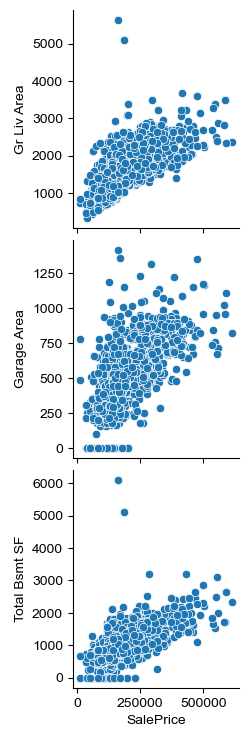

In [17]:
# plot for the numerical ones among the strongest features, which are 'Gr Liv Area', 'Garage Area' and 'Total Bsmt SF'.
sns.pairplot(df, y_vars=top_corr_features.index[[1,2,4]], x_vars=['SalePrice'])
sns.set(rc={'figure.figsize':(6,5)})

In [18]:
# plot for categorical features among the top 5 strongest features, which are 'Overall Qual' and 'Garage Cars'.
sns.boxplot(data=df[['Overall Qual','Garage Cars']])
sns.set(rc={'figure.figsize':(5,3)})

In [19]:
by_neighborhood = df.groupby(['Neighborhood'])['SalePrice'].mean()
by_neighborhood.sort_values(ascending=False,inplace=True)
by_neighborhood.plot(kind='bar', title='SalePrice by Neighborhood', ylabel='Mean SalePrice',
         xlabel='Neighborhood', figsize=(6.8, 3))

<AxesSubplot:title={'center':'SalePrice by Neighborhood'}, xlabel='Neighborhood', ylabel='Mean SalePrice'>

In [20]:
%store df

Stored 'df' (DataFrame)


In [21]:
%store df2_test

Stored 'df2_test' (DataFrame)
